### MobileNet 전이학습으로 이미지 분류하기

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6538 - loss: 0.7088

63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6551 - loss: 0.7064 - val_accuracy: 0.9300 - val_loss: 0.1877
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8842 - loss: 0.2861

63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8843 - loss: 0.2858 - val_accuracy: 0.9700 - val_loss: 0.1069
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9196 - loss: 0.1987 - val_accuracy: 0.9700 - val_loss: 0.0752
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9212 - loss: 0.1913

63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9211 - loss: 0.1913 - val_accuracy: 0.9800 - val_loss: 0.0729
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9303 - loss: 0.1676 - val_accuracy: 0.9800 - val_loss: 0.0548
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9603 - loss: 0.1245 - val_accuracy: 0.9800 - val_loss: 0.0483
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9503 - loss: 0.1399

63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9503 - loss: 0.1399 - val_accuracy: 0.9900 - val_loss: 0.0425
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9545 - loss: 0.1222 - val_accuracy: 0.9850 - val_loss: 0.0408
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9542 - loss: 0.1124 - val_accuracy: 0.9850 - val_loss: 0.0393
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9601 - loss: 0.1092 - val_accuracy: 0.9900 - val_loss: 0.0385
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9881 - loss: 0.0394
Test Accuracy: 0.9900


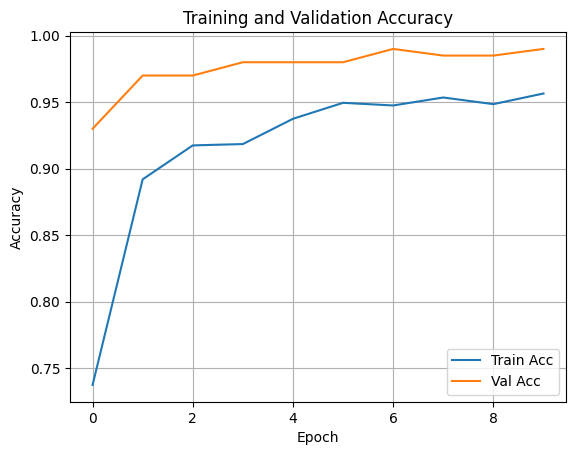

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 경로 설정
base_dir = 'PetImages'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 하이퍼파라미터
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 불러오기
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# MobileNet base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # 학습되지 않도록 고정 (Feature Extractor로 사용)

# 분류기 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 콜백
checkpoint = ModelCheckpoint("mobilenet_best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3)

# 학습
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)

# 평가
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

# 시각화
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# 평가
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

# classification_report 추가
# 1. 예측값 계산 (확률)
y_pred_prob = model.predict(test_generator)
# 2. 이진값으로 변환 (임계값 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. 실제 레이블
y_true = test_generator.classes

# 4. 라벨 이름 추출
label_names = list(test_generator.class_indices.keys())

# 5. 결과 출력
print("\n<Classification Report>")
print(classification_report(y_true, y_pred, target_names=label_names))

# 혼동 행렬
print("<Confusion Matrix>")
print(confusion_matrix(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 875ms/step - accuracy: 0.9881 - loss: 0.0394
Test Accuracy: 0.9900
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 909ms/step

<Classification Report>
              precision    recall  f1-score   support

         cat       1.00      0.98      0.99       100
         dog       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

<Confusion Matrix>
[[ 98   2]
 [  0 100]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


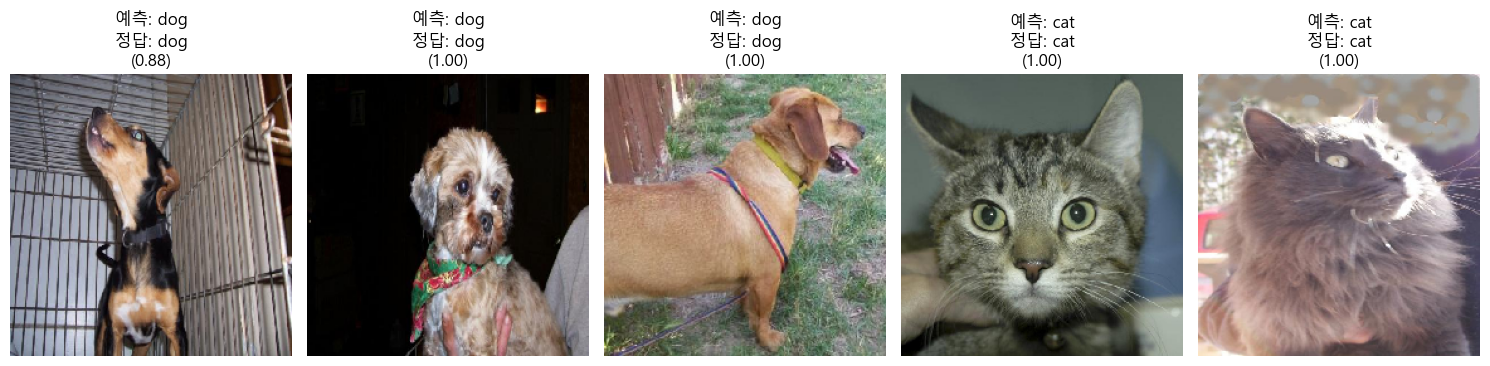

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# 테스트 폴더 경로
test_dir = 'PetImages/test'
class_names = ['cat', 'dog']
img_size = (224, 224)

# 테스트 이미지 경로 모으기
all_test_images = []
for label in class_names:
    class_folder = os.path.join(test_dir, label)
    for fname in os.listdir(class_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_test_images.append((os.path.join(class_folder, fname), label))

# 무작위로 n개 선택
n = 5
samples = random.sample(all_test_images, n)

# 예측 및 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(15, 5))

for i, (img_path, true_label) in enumerate(samples):
    # 이미지 로드 및 전처리
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # MobileNet은 0~1 스케일
    img_exp = np.expand_dims(img_array, axis=0)

    # 예측
    pred_prob = model.predict(img_exp)[0][0]
    pred_label = 'dog' if pred_prob > 0.5 else 'cat'
    confidence = pred_prob if pred_label == 'dog' else 1 - pred_prob

    # 시각화
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.title(f"예측: {pred_label}\n정답: {true_label}\n({confidence:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()


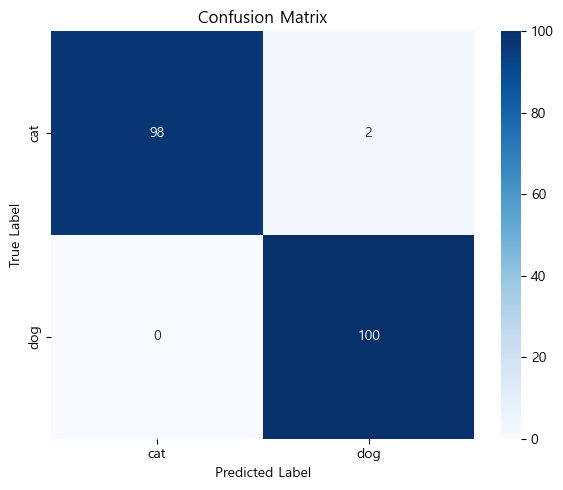

In [ ]:
import seaborn as sns 

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 클래스 이름 (test_generator에서 추출)
class_names = list(test_generator.class_indices.keys())

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

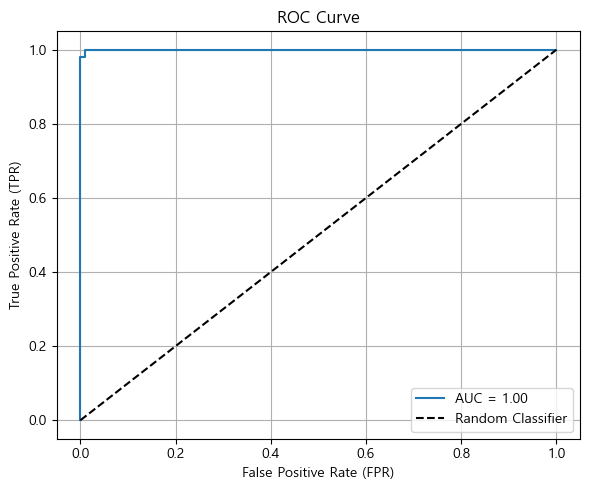

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()